In [49]:
# ML system for classifying Google location reviews quality and relevance
# Labels:
# 0: Low Quality
# 1: High Quality
# 2: Fake
# 3: Irrelevant
# 4: Advertisement

import warnings
warnings.filterwarnings("ignore")

import os
import re
import math
import pandas as pd
import numpy as np
from typing import List, Optional, Tuple

from urllib.parse import urlparse

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Optional deep models
try:
    from sentence_transformers import CrossEncoder
    CROSSENCODER_AVAILABLE = True
except Exception:
    CROSSENCODER_AVAILABLE = False

DATA_PATH = "dataset/final_df.csv"
OUTPUT_PATH = "dataset/predictions.csv"



In [50]:
# Load dataset and basic preprocessing

df = pd.read_csv(DATA_PATH)

# Normalize expected columns
TEXT_COL = "Review Text"
PLACE_WEBSITE_COL = "website"
BUSINESS_NAME_COL = "Business Name"
ADDRESS_COL = "Address"
CATEGORY_COL = "Category"
LANG_COL = "lang_code" if "lang_code" in df.columns else None
REVIEW_LEN_COL = "review_length" if "review_length" in df.columns else None
EMPTY_COL = "empty_review" if "empty_review" in df.columns else None
EXISTING_TOPIC_REL_COL = "topic_relevance" if "topic_relevance" in df.columns else None

# Fill NaNs for text
df[TEXT_COL] = df[TEXT_COL].fillna("").astype(str)

# Convenience: basic lengths if not present
if REVIEW_LEN_COL is None:
    REVIEW_LEN_COL = "_auto_review_length"
    df[REVIEW_LEN_COL] = df[TEXT_COL].str.split().apply(len)

if EMPTY_COL is None:
    EMPTY_COL = "_auto_empty_review"
    df[EMPTY_COL] = df[TEXT_COL].str.strip().eq("").astype(int)

# Quick preview
df.head(3)


,Business Name,Review,Reviewer Name,Review Text,place_id,Business Rating,Total Reviews,Address,website,phone,Country Code,Category,empty_review,lang_code,Review Text Translated,is_translated,mapped_category,review_length,topic_relevance,review_label
0,Anytime Fitness,4,Than pohwai,,ChIJ08t6PjYP2jERi4sIp8Z1Sw0,4.7,215,"638 Jurong West Street 61, #03-01 Pioneer Mall",https://www.anytimefitness.sg/gyms/sg-0095/pio...,+65 8500 4500,SG,Gym,1,NaN,NaN,0,Gym,0,0.000000,0
1,Anytime Fitness,1,Rah,Management in this region is not the best! Not...,ChIJ08t6PjYP2jERi4sIp8Z1Sw0,4.7,215,"638 Jurong West Street 61, #03-01 Pioneer Mall",https://www.anytimefitness.sg/gyms/sg-0095/pio...,+65 8500 4500,SG,Gym,0,en,Management in this region is not the best! Not...,0,Gym,86,0.442945,1
2,Anytime Fitness,5,Lin HaiHong,感谢 Desmond 在关键时刻救了一位晕倒的女士，本人真心谢谢见义勇为的你.你是一位好员工...,ChIJ08t6PjYP2jERi4sIp8Z1Sw0,4.7,215,"638 Jurong West Street 61, #03-01 Pioneer Mall",https://www.anytimefitness.sg/gyms/sg-0095/pio...,+65 8500 4500,SG,Gym,0,zh-CN,Thank you Desmond for saving a woman who faint...,1,Gym,40,0.127851,1


In [51]:
# Rule-based detectors: Low Quality and Advertisement

URL_REGEX = re.compile(r"https?://\S+|www\.\S+", re.IGNORECASE)
SHORT_GENERIC_PATTERNS = [
    r"^good$", r"^nice$", r"^ok$", r"^okay$", r"^bad$", r"^meh$",
    r"^great$", r"^awesome$", r"^terrible$", r"^worst$", r"^best$",
]
SHORT_GENERIC_RE = re.compile("|".join(SHORT_GENERIC_PATTERNS), re.IGNORECASE)

AD_KEYWORDS = [
    "promo", "promotion", "discount", "sale", "deal", "sponsored", "visit our website",
    "click here", "buy now", "limited time", "offer", "coupon", "voucher"
]
AD_RE = re.compile(r"|".join([re.escape(k) for k in AD_KEYWORDS]), re.IGNORECASE)


def extract_urls(text: str) -> List[str]:
    return URL_REGEX.findall(text or "")


def is_low_quality(text: str, review_len: int, empty_flag: int, min_words: int = 8) -> bool:
    if empty_flag == 1:
        return True
    if review_len < min_words:
        # very short or generic
        if SHORT_GENERIC_RE.search(text.strip()) is not None:
            return True
        # short and mostly punctuation/emojis
        alnum_ratio = (sum(ch.isalnum() for ch in text) / max(1, len(text)))
        if alnum_ratio < 0.2:
            return True
    return False


def url_domain(url: str) -> Optional[str]:
    try:
        return urlparse(url).netloc
    except Exception:
        return None


def normalize_domain(domain: Optional[str]) -> Optional[str]:
    if domain is None:
        return None
    domain = domain.lower()
    if domain.startswith("www."):
        domain = domain[4:]
    return domain


def is_advertisement(text: str, place_website: Optional[str]) -> bool:
    urls = extract_urls(text)
    if not urls and AD_RE.search(text or "") is None:
        return False
    if urls:
        place_domain = normalize_domain(url_domain(place_website)) if place_website else None
        for u in urls:
            d = normalize_domain(url_domain(u))
            if d and place_domain and d.endswith(place_domain):
                # URL points to same business domain → not ad
                return False
        # external links present
        return True
    # No links but strong ad wording
    return AD_RE.search(text or "") is not None


# Apply rule detectors
rule_low_quality = df.apply(lambda r: is_low_quality(r[TEXT_COL], int(r[REVIEW_LEN_COL]), int(r[EMPTY_COL])), axis=1)
rule_ad = df.apply(lambda r: is_advertisement(r[TEXT_COL], r.get(PLACE_WEBSITE_COL, None)), axis=1)

df["rule_low_quality"] = rule_low_quality.astype(int)
df["rule_advertisement"] = rule_ad.astype(int)

# Preview counts
df[["rule_low_quality", "rule_advertisement"]].mean()


rule_low_quality      0.327009
rule_advertisement    0.037681
dtype: float64

In [52]:
# Relevance scoring: CrossEncoder (semantic relevance to location)

if CROSSENCODER_AVAILABLE:
    model_name = "cross-encoder/ms-marco-MiniLM-L-6-v2"
    cross_encoder = CrossEncoder(model_name)
else:
    cross_encoder = None


def build_relevance_queries(row: pd.Series) -> List[str]:
    fields = []
    for col in [BUSINESS_NAME_COL, ADDRESS_COL, CATEGORY_COL]:
        if col in row and pd.notnull(row[col]) and str(row[col]).strip():
            fields.append(str(row[col]))
    if not fields:
        return ["the reviewed location"]
    return ["; ".join(fields)]


def score_relevance_batch(texts: List[str], queries: List[str]) -> np.ndarray:
    if cross_encoder is None:
        # Fallback: use simple heuristic—character overlap ratio
        scores = []
        for t, q in zip(texts, queries):
            tset = set(t.lower().split())
            qset = set(q.lower().split())
            inter = len(tset & qset)
            denom = max(1, len(tset))
            scores.append(inter / denom)
        return np.array(scores, dtype=float)
    pairs = list(zip(queries, texts))
    return np.array(cross_encoder.predict(pairs), dtype=float)


# Compute relevance scores in mini-batches
BATCH = 256
relevance_scores = []
for i in range(0, len(df), BATCH):
    chunk = df.iloc[i:i+BATCH]
    texts = chunk[TEXT_COL].tolist()
    queries = [build_relevance_queries(r)[0] for _, r in chunk.iterrows()]
    relevance_scores.extend(score_relevance_batch(texts, queries))

df["semantic_relevance"] = np.array(relevance_scores)
df[["semantic_relevance"]].describe()


,semantic_relevance
count,3795.000000
mean,0.012835
std,0.040821
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,0.500000


In [53]:
# Fake detection heuristic
# Signals (weak but helpful): mentions of not visiting, generic praise without specifics, contradictions

FAKE_PATTERNS = [
    r"didn't visit", r"did not visit", r"haven't been", r"never been", r"not been there",
    r"paid review", r"sponsored review", r"fake review", r"bot review", r"looks nice*", r"seems good",
]
FAKE_RE = re.compile("|".join(FAKE_PATTERNS), re.IGNORECASE)

GENERIC_PRAISE = re.compile(r"(great|nice|good|amazing|awesome) (place|spot|location|shop|store)\b", re.IGNORECASE)


def fake_score(text: str) -> float:
    if not text or not text.strip():
        return 0.0
    s = 0.0
    if FAKE_RE.search(text):
        s += 0.7
    if GENERIC_PRAISE.search(text):
        s += 0.2
    # too many exclamations can be suspicious
    if text.count("!") >= 3:
        s += 0.1
    return min(1.0, s)


df["fake_score"] = df[TEXT_COL].apply(fake_score)
df[["fake_score"]].describe()


,fake_score
count,3795.000000
mean,0.007615
std,0.036047
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,0.700000


In [54]:
# Final combiner: produce labels 0-4
# Priority: Advertisement (4) > Irrelevant (3) > Fake (2) > Low Quality (0) > High Quality (1)

# Thresholds
SEMANTIC_REL_THR = 0.25 if not CROSSENCODER_AVAILABLE else 0.35
FAKE_THR = 0.6


def assign_label(row: pd.Series) -> int:
    # 4. Advertisement
    if int(row.get("rule_advertisement", 0)) == 1:
        return 4
    # 3. Irrelevant (low semantic relevance)
    if float(row.get("semantic_relevance", 0.0)) < SEMANTIC_REL_THR:
        return 3
    # 2. Fake (heuristic)
    if float(row.get("fake_score", 0.0)) >= FAKE_THR:
        return 2
    # 0. Low quality (rule)
    if int(row.get("rule_low_quality", 0)) == 1:
        return 0
    # 1. High quality otherwise
    return 1


df["pred_label"] = df.apply(assign_label, axis=1)

# Attach label names for readability
ID2LABEL = {0: "Low Quality", 1: "High Quality", 2: "Fake", 3: "Irrelevant", 4: "Advertisement"}
df["pred_label_name"] = df["pred_label"].map(ID2LABEL)

df[["pred_label", "pred_label_name"]].value_counts(normalize=True)


pred_label  pred_label_name
3           Irrelevant         0.955731
4           Advertisement      0.037681
1           High Quality       0.006588
dtype: float64

In [55]:
# Save predictions

output_cols = [BUSINESS_NAME_COL, TEXT_COL, PLACE_WEBSITE_COL, ADDRESS_COL, CATEGORY_COL,
               "rule_low_quality", "rule_advertisement", "fake_score", "semantic_relevance",
               "pred_label", "pred_label_name"]

for c in list(output_cols):
    if c not in df.columns:
        output_cols.remove(c)

pred_df = df[output_cols].copy()
pred_df.to_csv(OUTPUT_PATH, index=False)

OUTPUT_PATH


'dataset/predictions.csv'

In [56]:
# Robustness fixes: safe URL/text handling and improved ad detection

def safe_text(x) -> str:
    return x if isinstance(x, str) else ""


def is_nonempty_str(x) -> bool:
    return isinstance(x, str) and x.strip() != ""


def url_domain(url: Optional[str]) -> Optional[str]:
    if not is_nonempty_str(url):
        return None
    try:
        return urlparse(url).netloc
    except Exception:
        return None


def normalize_domain(domain: Optional[str]) -> Optional[str]:
    if not is_nonempty_str(domain):
        return None
    d = domain.lower()
    if d.startswith("www."):
        d = d[4:]
    return d


def extract_urls(text: str) -> List[str]:
    return URL_REGEX.findall(safe_text(text))


def is_advertisement(text: str, place_website: Optional[str]) -> bool:
    urls = extract_urls(text)
    has_ad_words = AD_RE.search(safe_text(text)) is not None

    if urls:
        place_domain = normalize_domain(url_domain(place_website))
        link_domains = [normalize_domain(url_domain(u)) for u in urls]
        # External if any link domain does not end with the place domain
        external_found = False
        for d in link_domains:
            if d is None:
                continue
            if place_domain is None or not d.endswith(place_domain):
                external_found = True
                break
        if external_found:
            return True
        # Only in-domain links → not an ad by rule
        return False

    # No links: treat strong promotional wording as ad
    return has_ad_words


# Recompute with robust ad detection and keep low_quality as before
df["rule_advertisement"] = df.apply(lambda r: is_advertisement(r[TEXT_COL], r.get(PLACE_WEBSITE_COL, None)), axis=1).astype(int)


In [57]:
# Recompute predictions with updated rules

df["pred_label"] = df.apply(assign_label, axis=1)
df["pred_label_name"] = df["pred_label"].map(ID2LABEL)

pred_df = df[[c for c in [BUSINESS_NAME_COL, TEXT_COL, PLACE_WEBSITE_COL, ADDRESS_COL, CATEGORY_COL,
               "rule_low_quality", "rule_advertisement", "fake_score", "semantic_relevance",
               "pred_label", "pred_label_name"] if c in df.columns]].copy()

pred_df.to_csv(OUTPUT_PATH, index=False)
OUTPUT_PATH


'dataset/predictions.csv'

In [58]:
# Supervised training setup using final_df's review_label

LABEL_COL = "review_label" if "review_label" in df.columns else None
assert LABEL_COL is not None, "The dataset must contain 'review_label' (0-4)."

# Filter rows with non-null labels
train_df = df[df[LABEL_COL].notnull()].copy()
train_df[LABEL_COL] = train_df[LABEL_COL].astype(int)

# Feature: use review text only for now; rules can be added as features later
X_text = train_df[TEXT_COL].fillna("").astype(str).tolist()
y = train_df[LABEL_COL].values

# Split
X_train_text, X_val_text, y_train, y_val = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)

# Vectorizer
tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=3,
    max_df=0.95,
    strip_accents='unicode',
    lowercase=True,
)
X_train = tfidf.fit_transform(X_train_text)
X_val = tfidf.transform(X_val_text)

X_train.shape, X_val.shape


((3036, 6537), (759, 6537))

In [59]:
# Train TF-IDF + Logistic Regression classifier

# Class weights to counter imbalance
classes, counts = np.unique(y_train, return_counts=True)
class_weight = {int(c): float(len(y_train) / (len(classes) * n)) for c, n in zip(classes, counts)}

logreg = LogisticRegression(
    max_iter=2000,
    n_jobs=-1,
    class_weight=class_weight,
    multi_class='auto',
)
logreg.fit(X_train, y_train)

# Evaluate
y_val_pred = logreg.predict(X_val)
print(classification_report(y_val, y_val_pred, digits=3))


              precision    recall  f1-score   support

           0      0.877     0.929     0.902       322
           1      0.919     0.883     0.901       412
           2      0.000     0.000     0.000         7
           3      0.167     0.167     0.167        18

    accuracy                          0.877       759
   macro avg      0.491     0.495     0.492       759
weighted avg      0.875     0.877     0.876       759



In [60]:
# Combine model prediction with rule overrides (ads) and export

# Fit on all labeled text for final model
full_X = tfidf.fit_transform(df[TEXT_COL].fillna("").astype(str))
full_y = df[LABEL_COL].fillna(-1).astype(int)  # -1 for unlabeled

# Retrain on labeled rows only
mask_labeled = full_y >= 0
final_clf = LogisticRegression(
    max_iter=2000,
    n_jobs=-1,
    class_weight='balanced',
)
final_clf.fit(full_X[mask_labeled], full_y[mask_labeled])

# Predict all rows
proba_all = final_clf.predict_proba(full_X)
pred_all = proba_all.argmax(axis=1)

# Ad override takes precedence
pred_all = np.where(df["rule_advertisement"].values == 1, 4, pred_all)

# Keep low-quality override for empty/very short reviews
pred_all = np.where(df["rule_low_quality"].values == 1, 0, pred_all)

# Save
ID2LABEL = {0: "Low Quality", 1: "High Quality", 2: "Fake", 3: "Irrelevant", 4: "Advertisement"}
df["ml_pred_label"] = pred_all
df["ml_pred_label_name"] = df["ml_pred_label"].map(ID2LABEL)

out_cols = [BUSINESS_NAME_COL, TEXT_COL, PLACE_WEBSITE_COL, ADDRESS_COL, CATEGORY_COL,
            "ml_pred_label", "ml_pred_label_name",
            "rule_low_quality", "rule_advertisement"]

predictions_ml = df[[c for c in out_cols if c in df.columns]].copy()
predictions_ml.to_csv("dataset/predictions.csv", index=False)
"dataset/predictions.csv"


'dataset/predictions.csv'

In [61]:
# Evaluation: accuracy/F1 on a stratified validation split (with and without overrides)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Recreate split using indices to align overrides
train_df_eval = df[df["review_label"].notnull()].copy()
train_df_eval["review_label"] = train_df_eval["review_label"].astype(int)

y_all = train_df_eval["review_label"].values
idx_all = np.arange(len(train_df_eval))
train_idx, val_idx, y_train_e, y_val_e = train_test_split(
    idx_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

X_train_text_e = train_df_eval.iloc[train_idx][TEXT_COL].fillna("").astype(str).tolist()
X_val_text_e = train_df_eval.iloc[val_idx][TEXT_COL].fillna("").astype(str).tolist()

tfidf_eval = TfidfVectorizer(
    ngram_range=(1,2), min_df=3, max_df=0.95, strip_accents='unicode', lowercase=True
)
X_train_eval = tfidf_eval.fit_transform(X_train_text_e)
X_val_eval = tfidf_eval.transform(X_val_text_e)

clf_eval = LogisticRegression(max_iter=2000, n_jobs=-1, class_weight='balanced')
clf_eval.fit(X_train_eval, y_train_e)

# Predictions without overrides
val_pred = clf_eval.predict(X_val_eval)
acc_no_override = accuracy_score(y_val_e, val_pred)
print("Accuracy (no overrides):", round(acc_no_override, 4))
print(classification_report(y_val_e, val_pred, digits=3))
print("Confusion matrix (no overrides):\n", confusion_matrix(y_val_e, val_pred))

# Apply overrides on validation subset
val_rules_ad = train_df_eval.iloc[val_idx]["rule_advertisement"].values.astype(int)
val_rules_lq = train_df_eval.iloc[val_idx]["rule_low_quality"].values.astype(int)
val_pred_over = val_pred.copy()
val_pred_over = np.where(val_rules_ad == 1, 4, val_pred_over)
val_pred_over = np.where(val_rules_lq == 1, 0, val_pred_over)

acc_override = accuracy_score(y_val_e, val_pred_over)
print("\nAccuracy (with ad/low-quality overrides):", round(acc_override, 4))
print(classification_report(y_val_e, val_pred_over, digits=3))
print("Confusion matrix (with overrides):\n", confusion_matrix(y_val_e, val_pred_over))


Accuracy (no overrides): 0.8775
              precision    recall  f1-score   support

           0      0.877     0.929     0.902       322
           1      0.919     0.883     0.901       412
           2      0.000     0.000     0.000         7
           3      0.167     0.167     0.167        18

    accuracy                          0.877       759
   macro avg      0.491     0.495     0.492       759
weighted avg      0.875     0.877     0.876       759

Confusion matrix (no overrides):
 [[299  18   1   4]
 [ 34 364   3  11]
 [  0   7   0   0]
 [  8   7   0   3]]

Accuracy (with ad/low-quality overrides): 0.8406
              precision    recall  f1-score   support

           0      0.879     0.929     0.903       322
           1      0.921     0.816     0.865       412
           2      0.000     0.000     0.000         7
           3      0.167     0.167     0.167        18
           4      0.000     0.000     0.000         0

    accuracy                          0.841   

In [62]:
# Enforce: reviews without text -> label 0 (Low Quality) with highest priority

# Redefine label combiner to prioritize low-quality first
def assign_label_strict(row: pd.Series) -> int:
    # 0. Low quality (empty/very short) takes highest precedence
    if int(row.get("rule_low_quality", 0)) == 1:
        return 0
    # 4. Advertisement
    if int(row.get("rule_advertisement", 0)) == 1:
        return 4
    # 3. Irrelevant (low semantic relevance)
    if float(row.get("semantic_relevance", 0.0)) < (0.25 if not CROSSENCODER_AVAILABLE else 0.35):
        return 3
    # 2. Fake (heuristic)
    if float(row.get("fake_score", 0.0)) >= 0.6:
        return 2
    # 1. High quality otherwise
    return 1

# Recompute predictions with strict rule
ID2LABEL = {0: "Low Quality", 1: "High Quality", 2: "Fake", 3: "Irrelevant", 4: "Advertisement"}
df["pred_label"] = df.apply(assign_label_strict, axis=1)
df["pred_label_name"] = df["pred_label"].map(ID2LABEL)

# Also enforce on ML predictions if present
if "ml_pred_label" in df.columns:
    df.loc[df["rule_low_quality"] == 1, "ml_pred_label"] = 0
    df["ml_pred_label_name"] = df["ml_pred_label"].map(ID2LABEL)

# Save
pred_cols = [BUSINESS_NAME_COL, TEXT_COL, PLACE_WEBSITE_COL, ADDRESS_COL, CATEGORY_COL,
             "rule_low_quality", "rule_advertisement", "fake_score", "semantic_relevance",
             "pred_label", "pred_label_name"]

pred_df_strict = df[[c for c in pred_cols if c in df.columns]].copy()
pred_df_strict.to_csv(OUTPUT_PATH, index=False)
OUTPUT_PATH


'dataset/predictions.csv'

WITHOUT OVERRIDES
               precision    recall  f1-score   support

  Low Quality      0.877     0.929     0.902       322
 High Quality      0.919     0.883     0.901       412
         Fake      0.000     0.000     0.000         7
   Irrelevant      0.167     0.167     0.167        18
Advertisement      0.000     0.000     0.000         0

    micro avg      0.877     0.877     0.877       759
    macro avg      0.393     0.396     0.394       759
 weighted avg      0.875     0.877     0.876       759



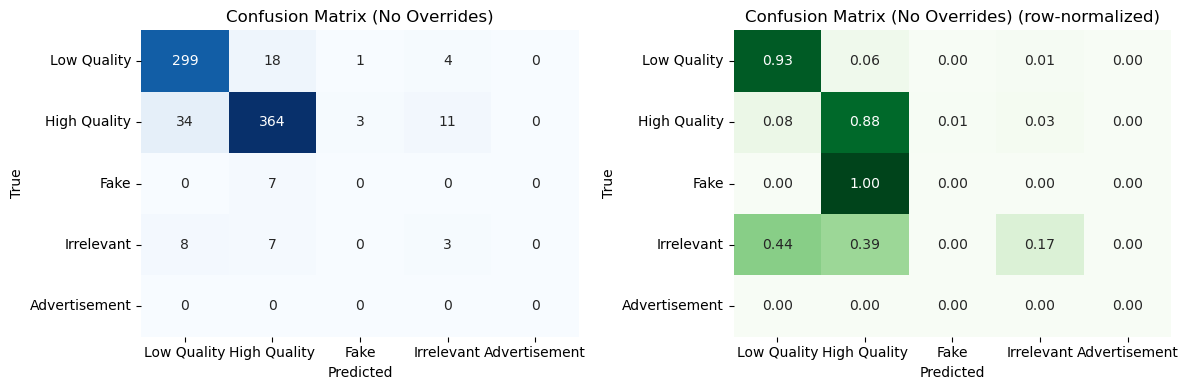


WITH OVERRIDES
               precision    recall  f1-score   support

  Low Quality      0.879     0.929     0.903       322
 High Quality      0.921     0.816     0.865       412
         Fake      0.000     0.000     0.000         7
   Irrelevant      0.167     0.167     0.167        18
Advertisement      0.000     0.000     0.000         0

     accuracy                          0.841       759
    macro avg      0.393     0.382     0.387       759
 weighted avg      0.877     0.841     0.857       759



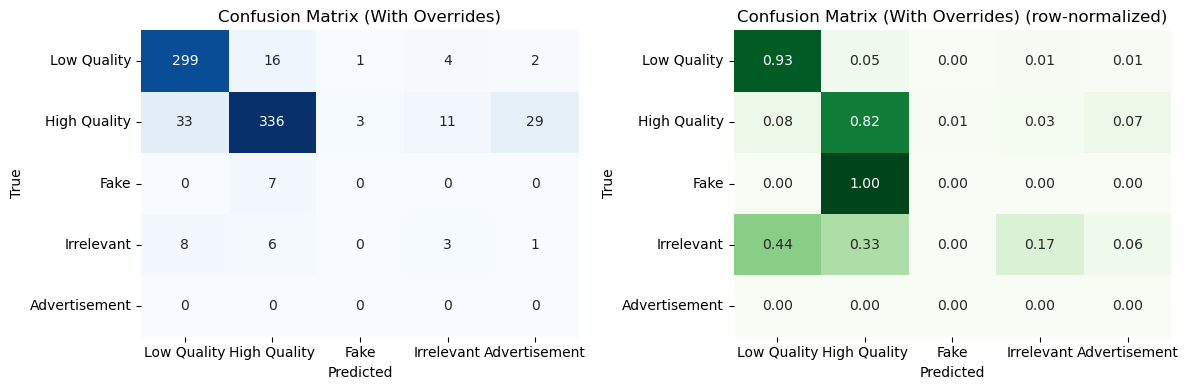

In [63]:
# Confusion matrix visualization and per-class metrics (validation split)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Rebuild a consistent eval split to avoid dependency on prior cells
_eval_df = df[df["review_label"].notnull()].copy()
_eval_df["review_label"] = _eval_df["review_label"].astype(int)
_y_all = _eval_df["review_label"].values
_idx_all = np.arange(len(_eval_df))
_tr_idx, _va_idx, _y_tr, _y_va = train_test_split(
    _idx_all, _y_all, test_size=0.2, random_state=42, stratify=_y_all
)
_Xtr_txt = _eval_df.iloc[_tr_idx][TEXT_COL].fillna("").astype(str).tolist()
_Xva_txt = _eval_df.iloc[_va_idx][TEXT_COL].fillna("").astype(str).tolist()
_vec = TfidfVectorizer(ngram_range=(1,2), min_df=3, max_df=0.95, strip_accents='unicode', lowercase=True)
_Xtr = _vec.fit_transform(_Xtr_txt)
_Xva = _vec.transform(_Xva_txt)
_clf = LogisticRegression(max_iter=2000, n_jobs=-1, class_weight='balanced')
_clf.fit(_Xtr, _y_tr)
_va_pred = _clf.predict(_Xva)

# With overrides
_va_pred_over = _va_pred.copy()
_va_rules_ad = _eval_df.iloc[_va_idx]["rule_advertisement"].values.astype(int)
_va_rules_lq = _eval_df.iloc[_va_idx]["rule_low_quality"].values.astype(int)
_va_pred_over = np.where(_va_rules_ad == 1, 4, _va_pred_over)
_va_pred_over = np.where(_va_rules_lq == 1, 0, _va_pred_over)

LABELS = [0,1,2,3,4]
LABEL_NAMES = {0:"Low Quality",1:"High Quality",2:"Fake",3:"Irrelevant",4:"Advertisement"}

def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=LABELS)
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=[LABEL_NAMES[l] for l in LABELS],
                yticklabels=[LABEL_NAMES[l] for l in LABELS], ax=ax[0])
    ax[0].set_xlabel('Predicted'); ax[0].set_ylabel('True'); ax[0].set_title(title)
    cm_norm = cm / cm.sum(axis=1, keepdims=True).clip(min=1)
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Greens', cbar=False,
                xticklabels=[LABEL_NAMES[l] for l in LABELS],
                yticklabels=[LABEL_NAMES[l] for l in LABELS], ax=ax[1])
    ax[1].set_xlabel('Predicted'); ax[1].set_ylabel('True'); ax[1].set_title(title + ' (row-normalized)')
    plt.tight_layout()
    plt.show()

print('WITHOUT OVERRIDES')
print(classification_report(_y_va, _va_pred, labels=LABELS, target_names=[LABEL_NAMES[l] for l in LABELS], digits=3))
plot_cm(_y_va, _va_pred, 'Confusion Matrix (No Overrides)')

print('\nWITH OVERRIDES')
print(classification_report(_y_va, _va_pred_over, labels=LABELS, target_names=[LABEL_NAMES[l] for l in LABELS], digits=3))
plot_cm(_y_va, _va_pred_over, 'Confusion Matrix (With Overrides)')
